In [ ]:
!pip install transformers sentence-transformers gradio faiss-cpu nltk requests beautifulsoup4


In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
import requests
import re
import time
import random
import numpy as np
import faiss
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import gradio as gr

# ====================== Web Scraper ======================
class WebScraper:
    def __init__(self, url_list, min_words=30000):
        self.url_queue = url_list.copy()
        self.collected_text = []
        self.total_words = 0
        self.min_words = min_words
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        }

    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,;?!-]', '', text)
        return text.lower().strip()

    def extract_content(self, soup):
        for tag in soup(['header', 'footer', 'nav', 'script', 'style', 'aside', 'form', 'figure']):
            tag.decompose()
        main_content = soup.find('main') or soup.find('article') or soup.find('div', class_=re.compile('content|main'))
        return ' '.join(p.get_text() for p in (main_content or soup).find_all(['p', 'h1', 'h2', 'h3'])) if main_content else ''

    def scrape_page(self, url):
        try:
            time.sleep(2 + random.random() * 3)
            response = requests.get(url, headers=self.headers, timeout=15)
            soup = BeautifulSoup(response.content, 'lxml')
            raw_text = self.extract_content(soup)
            clean_text = self.clean_text(raw_text)
            return clean_text
        except Exception as e:
            print(f"Error scraping {url}: {str(e)[:100]}")
            return ""

    def run(self):
        while self.url_queue and self.total_words < self.min_words:
            url = self.url_queue.pop(0)
            text = self.scrape_page(url)
            word_count = len(text.split())

            if word_count > 100:
                self.collected_text.append(text)
                self.total_words += word_count
                print(f"Added {word_count} words from {url} (Total: {self.total_words})")

        return self.collected_text

# ====================== Text Processor ======================
class TextProcessor:
    def __init__(self, chunk_size=250):
        self.chunk_size = chunk_size

    def process(self, texts):
        chunks = []
        for text in texts:
            sentences = sent_tokenize(text)
            current_chunk = []
            current_word_count = 0
            for sentence in sentences:
                words = sentence.split()
                if current_word_count + len(words) > self.chunk_size and current_chunk:
                    chunks.append(' '.join(current_chunk))
                    current_chunk = []
                    current_word_count = 0
                current_chunk.append(sentence)
                current_word_count += len(words)
            if current_chunk:
                chunks.append(' '.join(current_chunk))
        return chunks

# ====================== Local RAG System ======================
class LocalRAG:
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        self.index = None
        self.chunks = []
        self.tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta")
        self.model = AutoModelForCausalLM.from_pretrained(
            "HuggingFaceH4/zephyr-7b-beta",
            device_map="auto",
            torch_dtype=torch.float16
        )

    def create_index(self, chunks):
        self.chunks = chunks
        embeddings = self.embedder.encode(chunks, convert_to_tensor=True).cpu().numpy().astype('float32')
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

    def retrieve(self, query, top_k=3):
        query_embed = self.embedder.encode([query]).astype('float32')
        distances, indices = self.index.search(query_embed, top_k)
        return [self.chunks[i] for i in indices[0]]

    def generate(self, context, question):
        prompt = f"""<|system|>
Use this context to answer the question:
{''.join(context)}
</s>
<|user|>
{question}</s>
<|assistant|>"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(
            inputs.input_ids,
            max_new_tokens=256,
            temperature=0.7,
            do_sample=True,
            pad_token_id=self.tokenizer.eos_token_id
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

# ====================== Main Workflow ======================
websites = [
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://www.ibm.com/topics/machine-learning",
    "https://www.techtarget.com/searchenterpriseai/definition/machine-learning-ML"
]

scraper = WebScraper(websites, min_words=30000)
scraped_texts = scraper.run()

processor = TextProcessor(chunk_size=200)
chunks = processor.process(scraped_texts)
print(f"\nCreated {len(chunks)} text chunks")

rag = LocalRAG()
rag.create_index(chunks)
print("RAG system ready!")

# ====================== Gradio Interface ======================
def answer_question(question):
    context = rag.retrieve(question)
    answer = rag.generate(context, question)
    joined_context = "\n\n".join(context)
    return f"📘 **Context**:\n{joined_context}\n\n🤖 **Answer**:\n{answer}"

iface = gr.Interface(
    fn=answer_question,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question about machine learning...", label="Your Question"),
    outputs=gr.Textbox(label="Answer with Context"),
    title="RAG-based ML QA System",
    description="Ask a question and get answers using Retrieval-Augmented Generation (RAG) from scraped machine learning articles."
)

iface.launch()


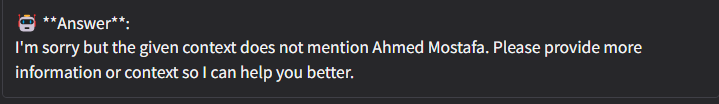